# Support & Resistance Lines Analysis

This notebook demonstrates how to compute and visualize support and resistance lines - key technical analysis concepts used in financial markets. Support and resistance levels represent price points where a security has historically had difficulty moving beyond, either on the downside (support) or upside (resistance).

The implementation uses:
- Peak detection algorithms to identify potential support/resistance levels
- Data visualization with Matplotlib and mplfinance

The notebook shows how to:
1. Load and process financial price data
2. Detect support and resistance levels using signal processing
3. Visualize the results


In [140]:
import os
from datetime import datetime
from typing import List

import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from scipy.signal import find_peaks

from src.metatrader import MT5Connection

# Load env vars
load_dotenv()

True

In [141]:
# Load data
symbol = "USDCAD"
timeframe = mt5.TIMEFRAME_M15
with (MT5Connection(int(os.getenv("ACCOUNT_ID")), os.getenv("PASSWORD"), os.getenv("MT5_SERVER")) as mt5_conn):
	data = mt5_conn.fetch_rates_range(symbol=symbol,
									  timeframe=timeframe,
									  date_from=datetime(2025, 4, 1),
									  date_to=datetime.now())

data.head()

,Open,High,Low,Close,Volume
time,,,,,
2025-03-31 21:00:00,1.43880,1.43897,1.43804,1.43851,2148
2025-03-31 21:15:00,1.43852,1.43860,1.43759,1.43760,1828
2025-03-31 21:30:00,1.43760,1.43805,1.43717,1.43742,1879
2025-03-31 21:45:00,1.43742,1.43788,1.43728,1.43760,2210
2025-03-31 22:00:00,1.43759,1.43801,1.43732,1.43746,2426


In [142]:
def compute_levels(rates: pd.DataFrame, window: int = 100, prominence: float = 0.002) -> tuple[List, List]:
	"""Computes support and resistance levels for a given financial time-series 
	dataframe. The computation is based on identified peaks in the "High" 
	and "Low" columns over a specified window and prominence level.

	Args:
	    rates (pd.DataFrame): A DataFrame containing financial time-series data.
	        It must include at least the "Low", "High", and "Close" columns.
	    window (int): The minimum distance between peaks to be considered 
	        significant. Defaults to 100.
	    prominence (float): The required prominence of the peaks to be 
	        used in calculating levels or, in other words, how much a peak stands 
	        out relative to its surrounding peaks. Defaults to 0.002.

	Returns:
	    tuple[List, List]: A tuple containing:
	        - support_lines (List): A list of arrays representing horizontal 
	            support lines based on peaks in the "Low" column.
	        - resistance_lines (List): A list of arrays representing horizontal 
	            resistance lines based on peaks in the "High" column.
	"""
	peaks, _ = find_peaks(-rates["Low"], distance=window, prominence=prominence)
	peaks_values = rates.iloc[peaks]["Close"]
	support_lines = [np.full(len(rates), val) for val in peaks_values]

	peaks, _ = find_peaks(rates["High"], distance=window, prominence=prominence)
	peaks_values = rates.iloc[peaks]["Close"]
	resistance_lines = [np.full(len(rates), val) for val in peaks_values]

	return support_lines, resistance_lines

In [146]:
# Functions visualize support and resistance levels
def plot_data_simple(rates: pd.DataFrame, support_lines: list, resistance_lines: list, depth: int = None):
	if depth is None:
		depth = len(rates)

	if depth > len(rates):
		raise ValueError("Depth is bigger than the size of the data.")

	min_price = min(rates[-depth:]["Close"])
	max_price = max(rates[-depth:]["Close"])

	time_axis = rates.index.tolist()

	plt.figure(figsize=(12, 6))
	plt.plot(time_axis[-depth:], rates[-depth:]["Close"], label="Close Price", color="blue")

	if resistance_lines:
		[plt.plot(time_axis[-depth:], resistance[-depth:], color="red", linestyle="--") for resistance in
		 resistance_lines if min_price <= resistance[0] <= max_price]
	if support_lines:
		[plt.plot(time_axis[-depth:], support[-depth:], color="green", linestyle="--") for support in support_lines if
		 min_price <= support[0] <= max_price]

	plt.xlabel("time")
	plt.ylabel("Price")
	plt.legend()
	plt.grid()
	plt.show()


def plot_data_with_candles(rates: pd.DataFrame, support_lines: list, resistance_lines: list, depth: int = None):
	if depth is None:
		depth = len(rates)

	min_price = min(rates[-depth:]["Close"])
	max_price = max(rates[-depth:]["Close"])

	suport_levels = [line[0] for line in support_lines if min_price <= line[0] <= max_price]
	resistance_levels = [line[0] for line in resistance_lines if min_price <= line[0] <= max_price]

	colors = ["g"] * len(suport_levels)
	colors.extend(["r"] * len(resistance_levels))

	# Prepare lines
	hlines = dict(
		hlines=suport_levels + resistance_levels,
		colors=colors,
		linestyle="--",
		alpha=0.5
	)

	plot_data = rates[-depth:].copy()
	plot_data.columns = [col.title() for col in plot_data.columns]  # Capitalize column names

	mc = mpf.make_marketcolors(
		up="green",
		down="red",
		edge="inherit",
		wick="inherit",
		volume="in"
	)
	s = mpf.make_mpf_style(marketcolors=mc)

	mpf.plot(
		plot_data,
		type="candle",
		style=s,
		title="Price with Support & Resistance Levels",
		hlines=hlines,
		figsize=(16, 9),
		volume=True
	)

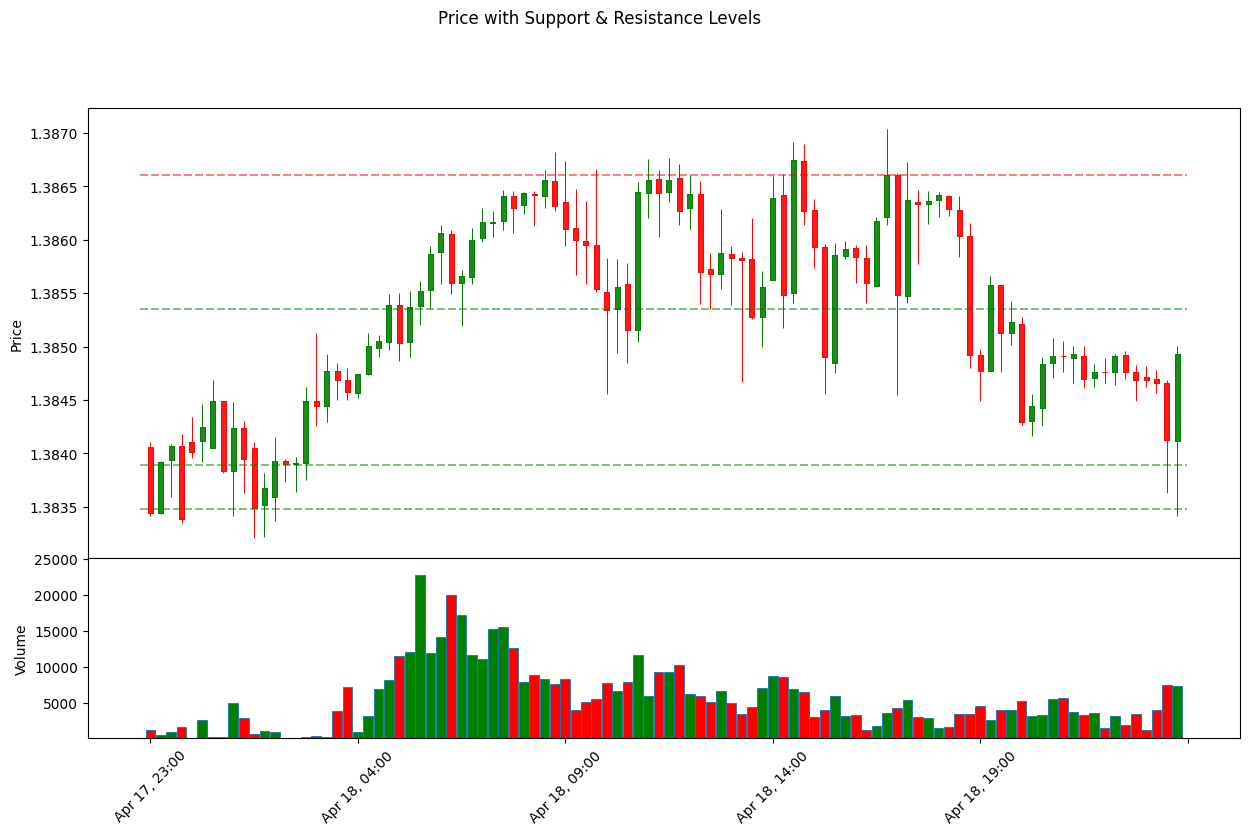

In [147]:
_support_lines, _resistance_lines = compute_levels(data, window=100, prominence=0.001)
plot_data_with_candles(rates=data, support_lines=_support_lines, resistance_lines=_resistance_lines, depth=100)